#Los datos se recopilaron del sitio web de la Agencia Internacional de Energía (AIE), específicamente de su herramienta Estadísticas mensuales de electricidad disponible en iea.org/data-and-statistics/data-tools/monthly-electricity-statistics
Estos datos filtrados incluyen información sobre la producción de energía en en Chile mensualmente desde 2010 hasta 2022. La producción de energía se mide en gigavatios-hora (GWh) y cubre una gama de productos energéticos que incluyen energía hidroeléctrica, eólica, solar, geotérmica, nuclear, fósil combustibles y otros.

In [4]:
#importamos lobrerias
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [5]:
#carga el archivo con la ruta en la que lo almacenas
data = pd.read_csv("/content/sample_data/chile_data.csv")

In [6]:
data.head()

COUNTRY CODE_TIME          TIME  YEAR  MONTH MONTH_NAME  \
0   Chile   JAN2010  January 2010  2010      1    January   
1   Chile   JAN2010  January 2010  2010      1    January   
2   Chile   JAN2010  January 2010  2010      1    January   
3   Chile   JAN2010  January 2010  2010      1    January   
4   Chile   JAN2010  January 2010  2010      1    January   

                   PRODUCT     VALUE  DISPLAY_ORDER  yearToDate  \
0                    Hydro  2277.808              1   21641.001   
1                     Wind    21.126              2     332.001   
2  Total combustible fuels  2472.143              7   36249.001   
3                     Coal  1287.305              8   15974.071   
4                      Oil   382.032              9    8022.080   

   previousYearToDate     share  
0                 NaN  0.476488  
1                 NaN  0.004419  
2                 NaN  0.517140  
3                 NaN  0.269288  
4                 NaN  0.079916

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3347 entries, 0 to 3346
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   COUNTRY             3347 non-null   object 
 1   CODE_TIME           3347 non-null   object 
 2   TIME                3347 non-null   object 
 3   YEAR                3347 non-null   int64  
 4   MONTH               3347 non-null   int64  
 5   MONTH_NAME          3347 non-null   object 
 6   PRODUCT             3347 non-null   object 
 7   VALUE               3347 non-null   float64
 8   DISPLAY_ORDER       3347 non-null   int64  
 9   yearToDate          3347 non-null   float64
 10  previousYearToDate  3009 non-null   float64
 11  share               3347 non-null   float64
dtypes: float64(4), int64(3), object(5)
memory usage: 313.9+ KB


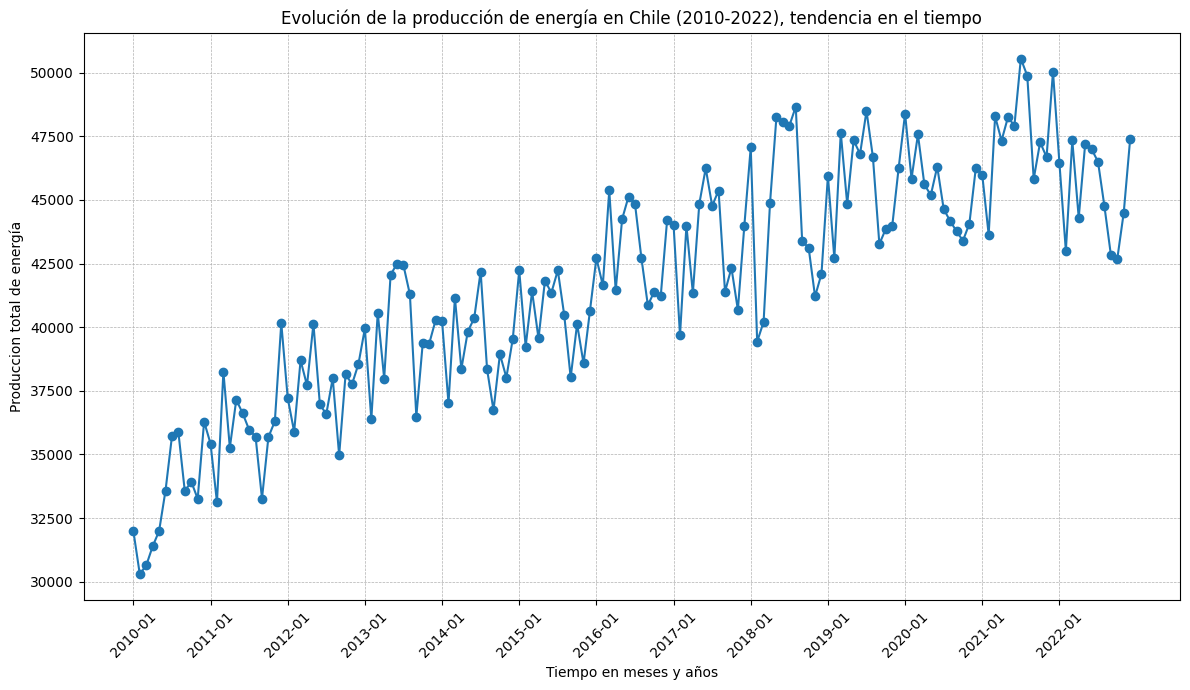

In [8]:
#agrupamos los datos por año y mes y sumamos el volr de producción de energía
tendencia = data.groupby(['YEAR', 'MONTH']).VALUE.sum().reset_index()

# Creamos una nueva columna para representar el tiempo en formato "YEAR-MONTH"
tendencia['TIME'] = tendencia['YEAR'].astype(str) + "-" + tendencia['MONTH'].astype(str).str.zfill(2)

plt.figure(figsize=(12,7))
plt.plot(tendencia['TIME'], tendencia['VALUE'], marker='o')
plt.xticks(tendencia['TIME'][::12], rotation=45)  #mostramos cada 12 meses en el eje x para mejor visualización
plt.xlabel('Tiempo en meses y años')
plt.ylabel('Produccion total de energía')
plt.title('Evolución de la producción de energía en Chile (2010-2022), tendencia en el tiempo')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


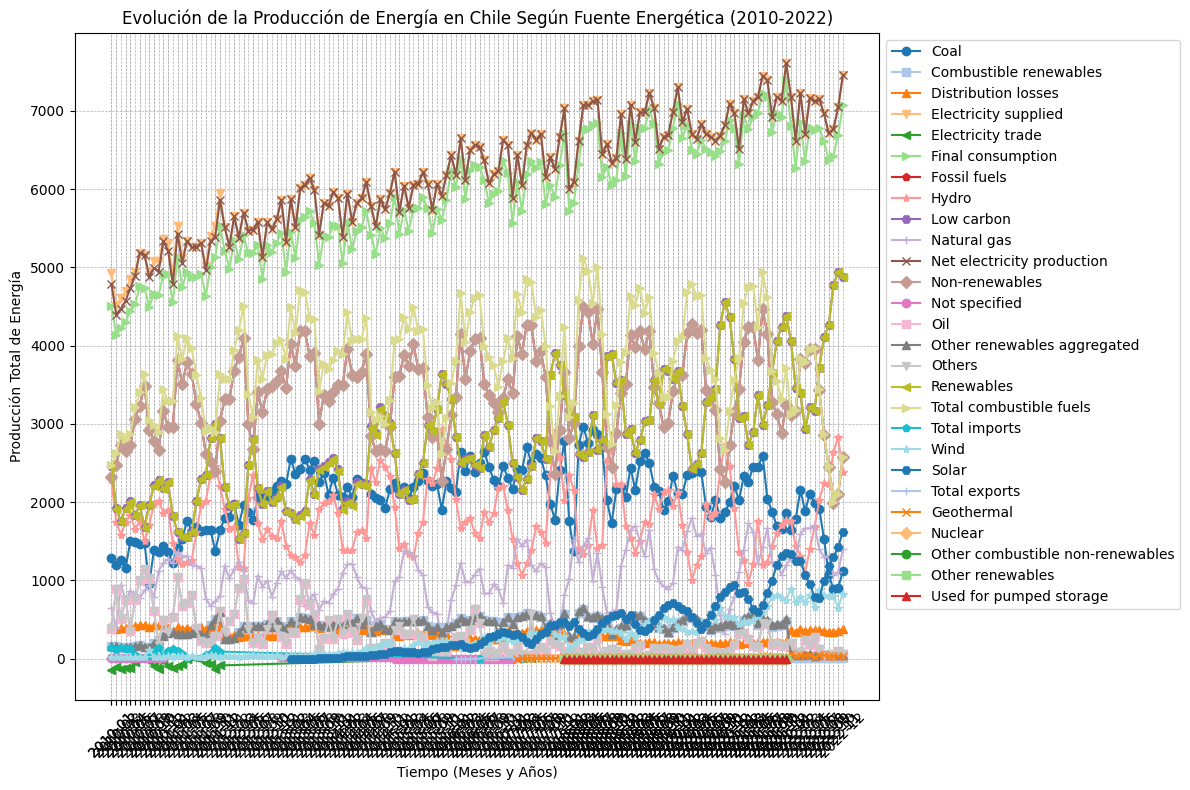

In [9]:
# Agrupamos los datos por año, mes y producto y sumamos el valor de producción de energía
tendencia_productos = data.groupby(['YEAR', 'MONTH', 'PRODUCT']).VALUE.sum().reset_index()

# Creamos una nueva columna para representar el tiempo en formato "YEAR-MONTH"
tendencia_productos['TIME'] = tendencia_productos['YEAR'].astype(str) + "-" + tendencia_productos['MONTH'].astype(str).str.zfill(2)
colors = plt.cm.tab20.colors    #paletade colores
markers = ['o', 's', '^', 'v', '<', '>', 'p', '*', 'H', '+', 'x', 'D']

# Graficar la producción de energía por producto a lo largo del tiempo con colores y marcadores distintos
plt.figure(figsize=(12,8))
products = tendencia_productos['PRODUCT'].unique()
for idx, product in enumerate(products):
    subset = tendencia_productos[tendencia_productos['PRODUCT'] == product]
    plt.plot(subset['TIME'], subset['VALUE'], color=colors[idx % len(colors)],
             marker=markers[idx % len(markers)], label=product, markersize=6, linestyle='-')

plt.xticks(tendencia_productos['TIME'][::12], rotation=45)  # Mostramos cada 12 meses en el eje x para mejor visualización
plt.xlabel('Tiempo (Meses y Años)')
plt.ylabel('Producción Total de Energía')
plt.title('Evolución de la Producción de Energía en Chile Según Fuente Energética (2010-2022)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

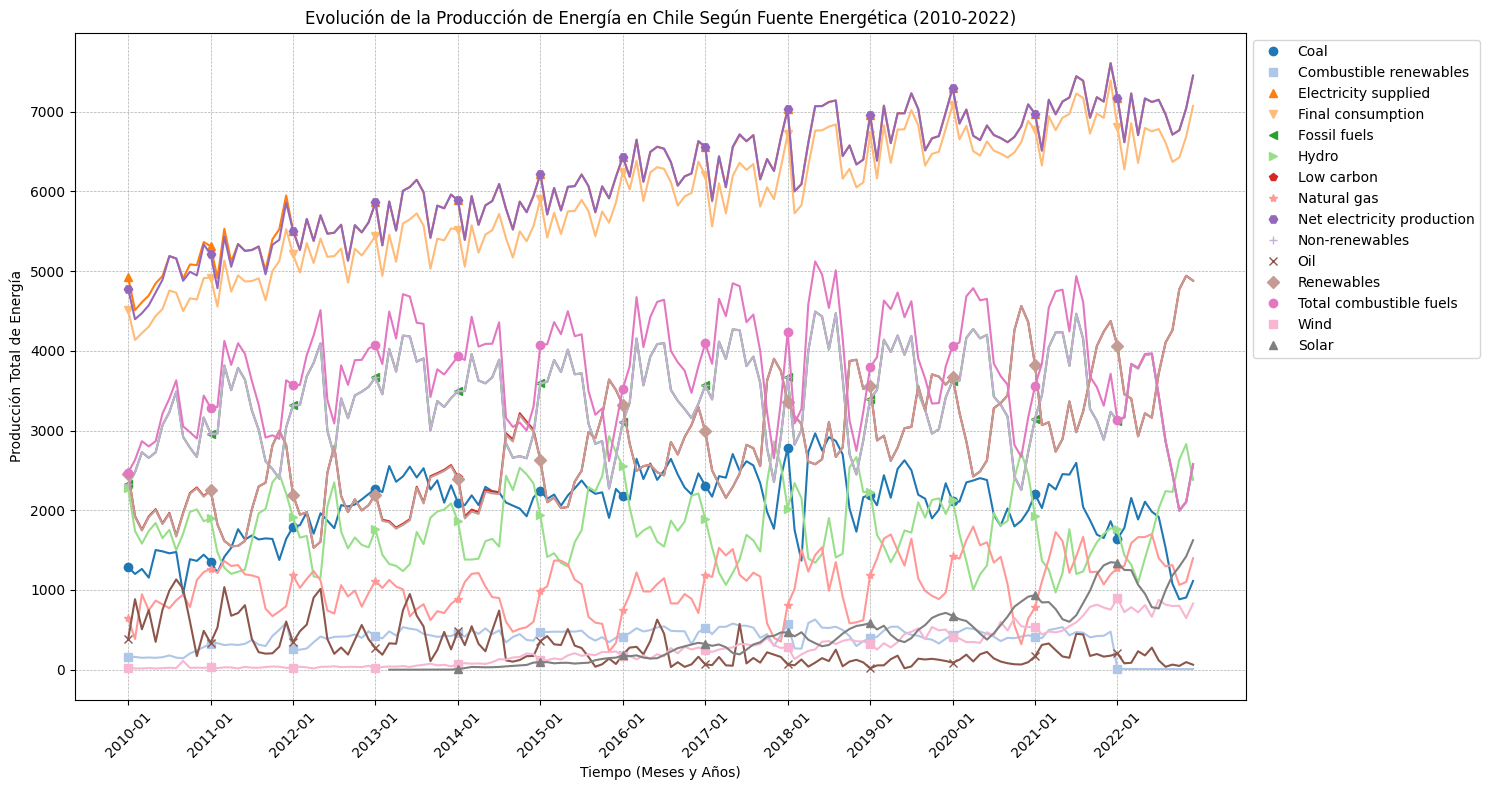

In [10]:
# Creamos una nueva columna para representar el tiempo en formato "YEAR-MONTH"
tendencia_productos['TIME'] = tendencia_productos['YEAR'].astype(str) + "-" + tendencia_productos['MONTH'].astype(str).str.zfill(2)

# Definimos una paleta de colores y marcadores
colors = plt.cm.tab20.colors
markers = ['o', 's', '^', 'v', '<', '>', 'p', '*', 'H', '+', 'x', 'D']

# Lista de fuentes de energía a excluir
fuentes_a_excluir = ["Used for pumped storage", "Nuclear", "Other combustible non-renewables", "Other renewables",
                     "Geothermal", "Not specified", "Total exports", "Total imports", "Others",
                     "Distribution losses", "Other renewables aggregated", "Electricity trade"]

# Filtrar el DataFrame para excluir las fuentes mencionadas
tendencia_productos_filtrado = tendencia_productos[~tendencia_productos['PRODUCT'].isin(fuentes_a_excluir)]

# Graficar la producción de energía por producto a lo largo del tiempo con colores y marcadores distintos solo en los años
# y corregir para que todos los marcadores y series aparezcan en la leyenda
plt.figure(figsize=(15,8))
legend_handles = []

products_filtrados = tendencia_productos_filtrado['PRODUCT'].unique()
for idx, product in enumerate(products_filtrados):
    subset = tendencia_productos_filtrado[tendencia_productos_filtrado['PRODUCT'] == product]

    # Dibujar la línea con marcadores solo en enero
    line, = plt.plot(subset['TIME'], subset['VALUE'], color=colors[idx % len(colors)],
                     linestyle='-', label=product, markerfacecolor='None')

    # Añadir marcadores solo para los puntos que corresponden a enero de cada año
    subset_enero = subset[subset['MONTH'] == 1]
    markers_on_line, = plt.plot(subset_enero['TIME'], subset_enero['VALUE'], color=colors[idx % len(colors)],
                                linestyle='', marker=markers[idx % len(markers)], markersize=6, label=product)

    # Añadir los marcadores y líneas a la lista de elementos de leyenda
    legend_handles.append(markers_on_line)

# Mostramos solo las fechas correspondientes a enero en el eje x
labels_enero = tendencia_productos_filtrado[tendencia_productos_filtrado['MONTH'] == 1]['TIME'].unique()
plt.xticks(labels_enero, labels_enero, rotation=45)
plt.xlabel('Tiempo (Meses y Años)')
plt.ylabel('Producción Total de Energía')
plt.title('Evolución de la Producción de Energía en Chile Según Fuente Energética (2010-2022)')
plt.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


#pasamos a preparar los datos
Vamos a:

- Sumar la producción total de energía por mes y año, sin discriminar por fuente.
- Identificar y seleccionar las fuentes de energía principales o aquellas con una tendencia al alza.

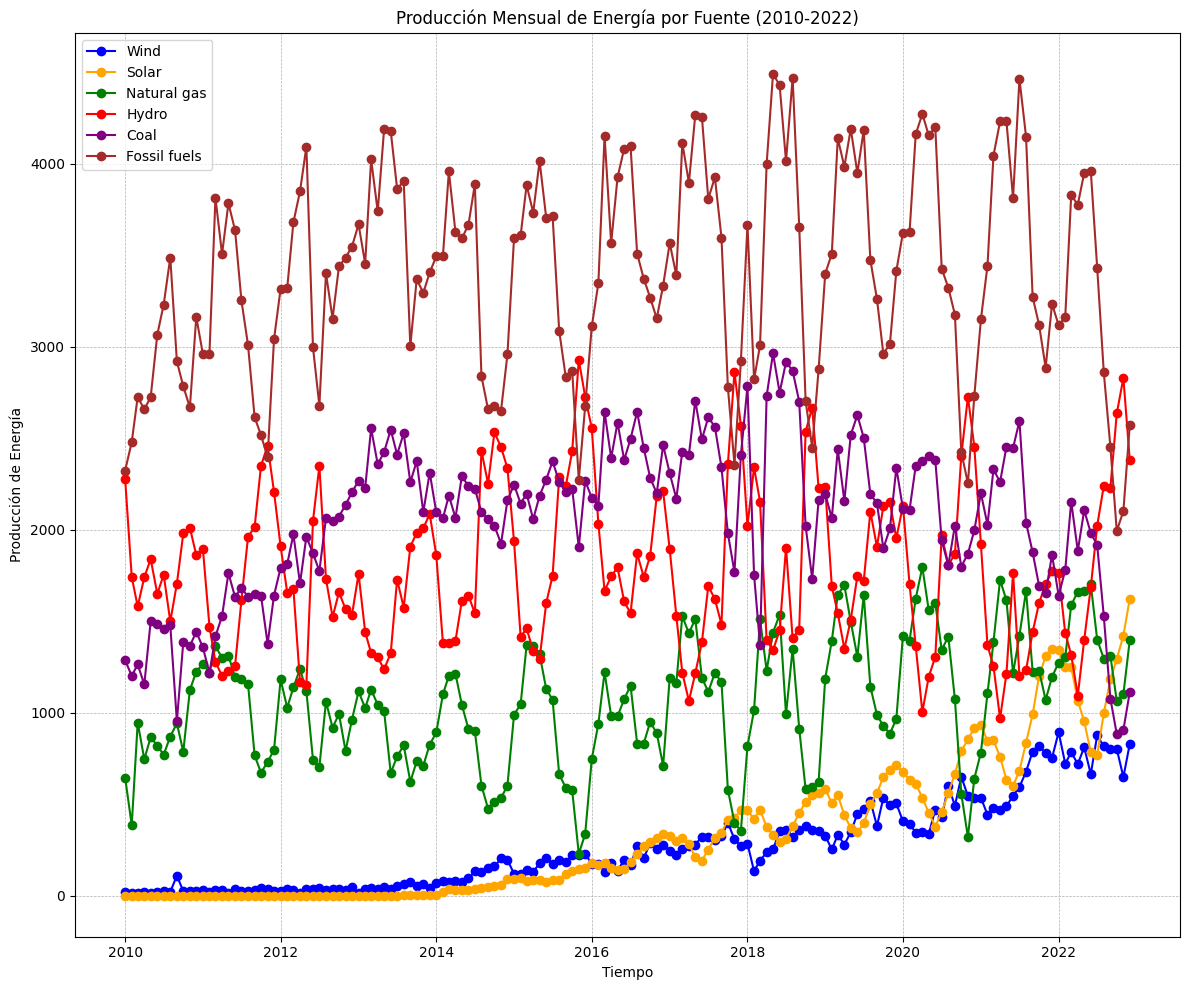

In [11]:
total_produccion_por_producto_mensual = data.groupby(['YEAR', 'MONTH', 'PRODUCT']).VALUE.sum().reset_index()
#convertimos el índice multi-nivel (YEAR, MONTH) a una serie de tiempo
serie_temporal_mensual = total_produccion_por_producto_mensual.pivot_table(index=['YEAR', 'MONTH'], columns='PRODUCT', values='VALUE', aggfunc='sum')
serie_temporal_mensual['TIME'] = pd.to_datetime(serie_temporal_mensual.index.map(lambda x: f"{x[0]}-{x[1]:02}-01"))
serie_temporal_mensual.set_index('TIME', inplace=True)
serie_temporal_mensual = serie_temporal_mensual.fillna(0)  # llenamos los valores faltantes con 0
#fuentes seleccionadas
fuentes_a_predecir = ["Wind", "Solar", "Natural gas", "Hydro", "Coal", "Fossil fuels"]
#paleta de colores
colors_distintos = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
#series temporales mensuales
plt.figure(figsize=(12, 10))
for idx, fuente in enumerate(fuentes_a_predecir):
    plt.plot(serie_temporal_mensual.index, serie_temporal_mensual[fuente], label=fuente, marker='o', color=colors_distintos[idx])

plt.xlabel('Tiempo')
plt.ylabel('Producción de Energía')
plt.title('Producción Mensual de Energía por Fuente (2010-2022)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Procedesmo con la descomposicion temporal de los elementos
La descomposición de una serie temporal implica descomponerla en tres componentes:

- Tendencia: Patrón subyacente a largo plazo en una serie, muestra evaluación en el tiempo.
- Estacionalidad: Patrón repetitivo a corto plazo en una serie, patrones mensuales, quizas relazionados con cantidad de sol diposnible.   
- Residuo: El resto después de haber extraído la tendencia y la estacionalidad.

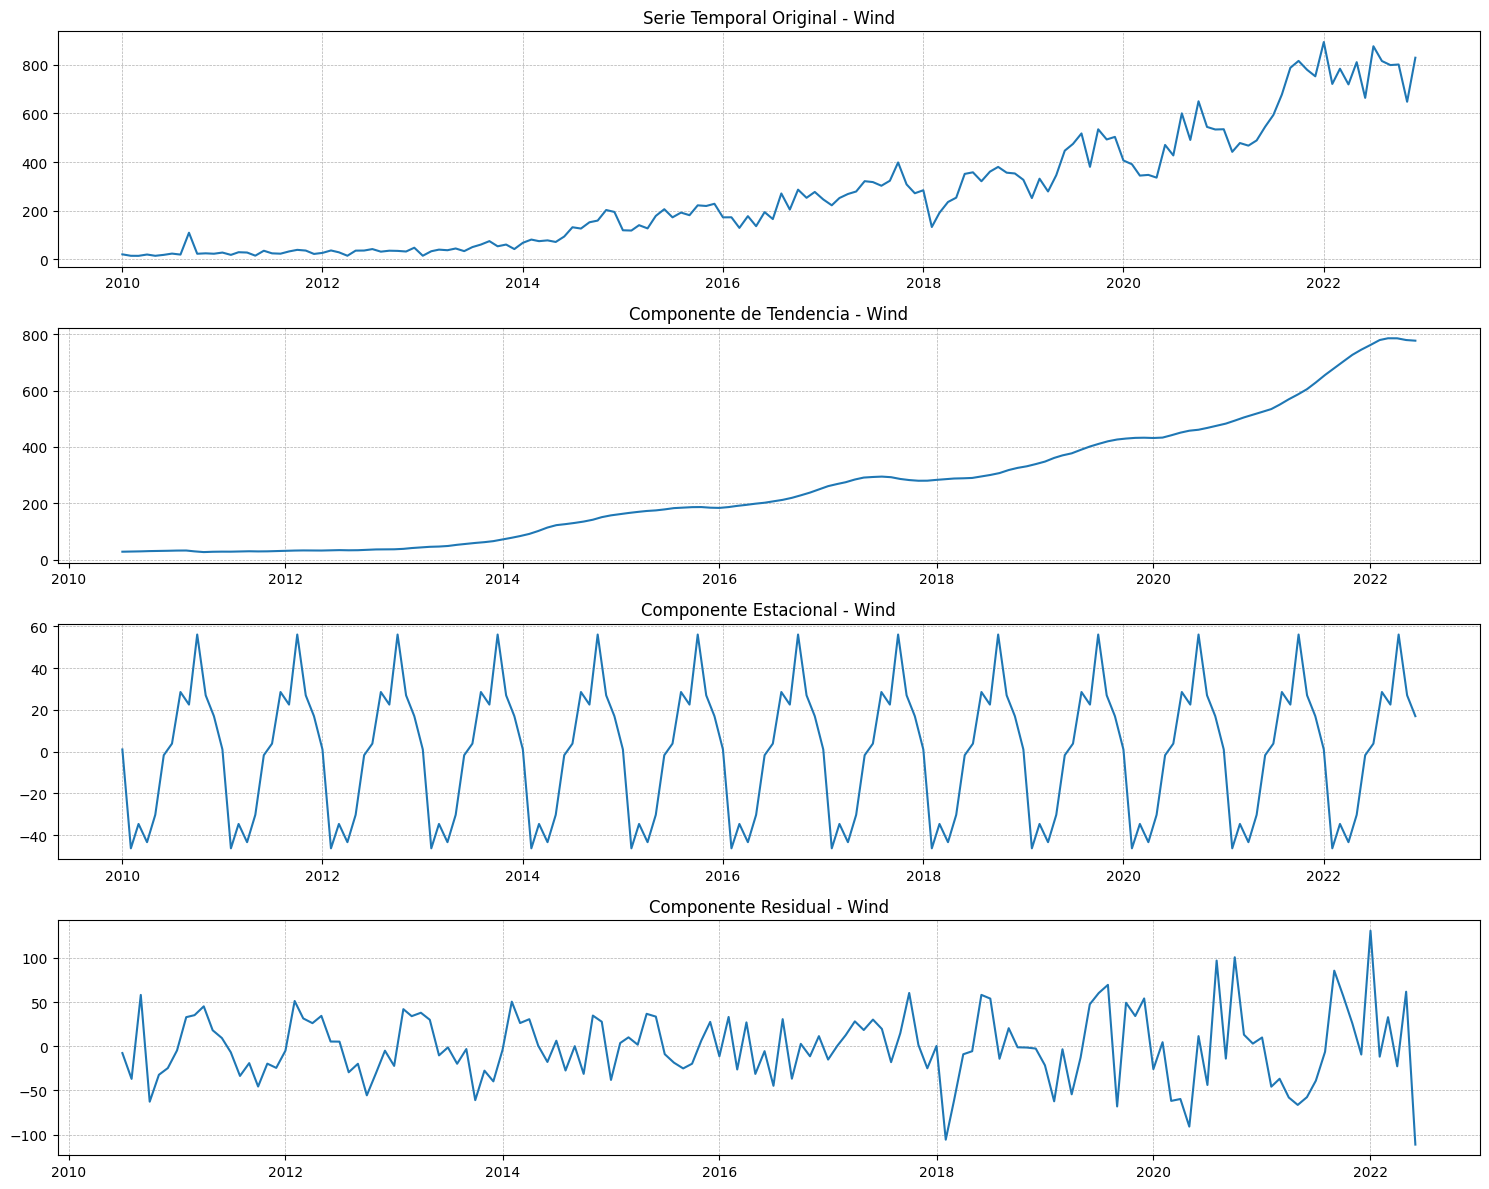

In [12]:
#preocedemos con la fuente eolica primero
from statsmodels.tsa.seasonal import seasonal_decompose
result_wind = seasonal_decompose(serie_temporal_mensual['Wind'], model='additive', period=12)
plt.figure(figsize=(15, 12))
#original
plt.subplot(4, 1, 1)
plt.plot(result_wind.observed)
plt.title('Serie Temporal Original - Wind')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#tendencia
plt.subplot(4, 1, 2)
plt.plot(result_wind.trend)
plt.title('Componente de Tendencia - Wind')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#estacionalidad
plt.subplot(4, 1, 3)
plt.plot(result_wind.seasonal)
plt.title('Componente Estacional - Wind')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#residuo
plt.subplot(4, 1, 4)
plt.plot(result_wind.resid)
plt.title('Componente Residual - Wind')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

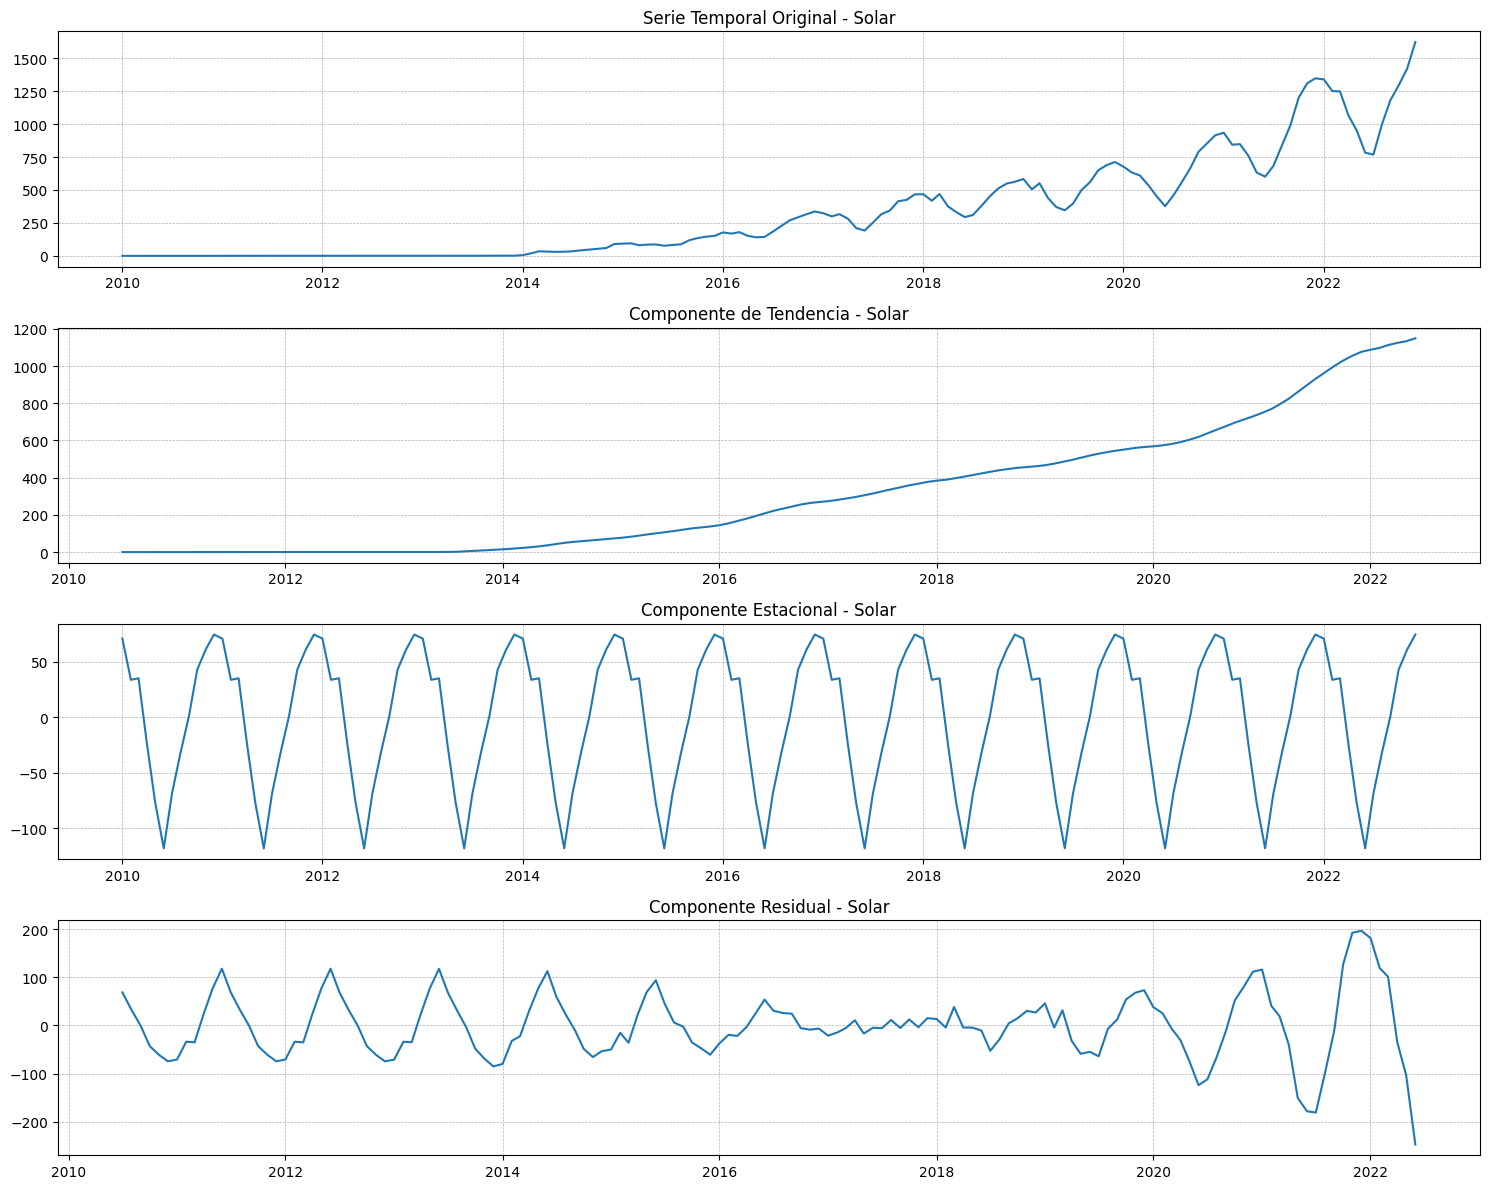

In [13]:
#fuente "Solar" usando el modelo aditivo
result_solar = seasonal_decompose(serie_temporal_mensual['Solar'], model='additive', period=12)
plt.figure(figsize=(15, 12))
#original
plt.subplot(4, 1, 1)
plt.plot(result_solar.observed)
plt.title('Serie Temporal Original - Solar')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#tendencia
plt.subplot(4, 1, 2)
plt.plot(result_solar.trend)
plt.title('Componente de Tendencia - Solar')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#estacionalidad
plt.subplot(4, 1, 3)
plt.plot(result_solar.seasonal)
plt.title('Componente Estacional - Solar')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#residuo
plt.subplot(4, 1, 4)
plt.plot(result_solar.resid)
plt.title('Componente Residual - Solar')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

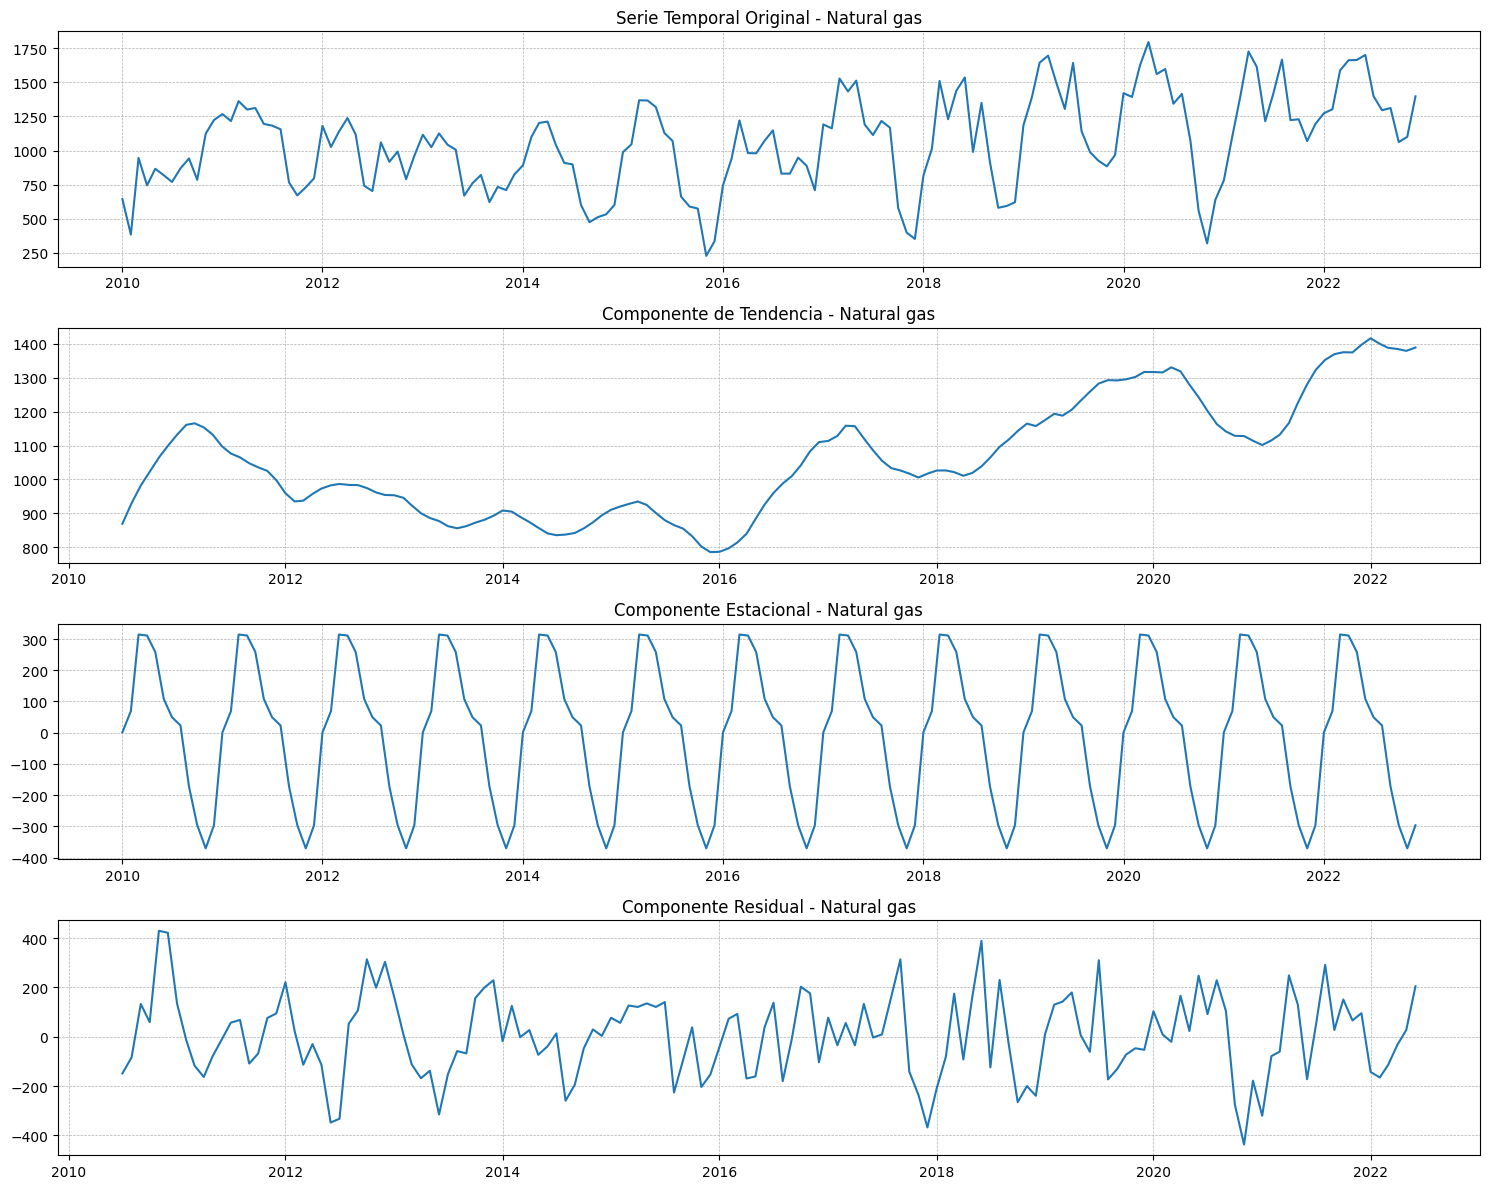

In [14]:
#fuente "Natural gas" usando el modelo aditivo
result_natural_gas = seasonal_decompose(serie_temporal_mensual['Natural gas'], model='additive', period=12)
plt.figure(figsize=(15, 12))
#original
plt.subplot(4, 1, 1)
plt.plot(result_natural_gas.observed)
plt.title('Serie Temporal Original - Natural gas')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#tendencia
plt.subplot(4, 1, 2)
plt.plot(result_natural_gas.trend)
plt.title('Componente de Tendencia - Natural gas')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#estacionalidad
plt.subplot(4, 1, 3)
plt.plot(result_natural_gas.seasonal)
plt.title('Componente Estacional - Natural gas')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#residuo
plt.subplot(4, 1, 4)
plt.plot(result_natural_gas.resid)
plt.title('Componente Residual - Natural gas')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

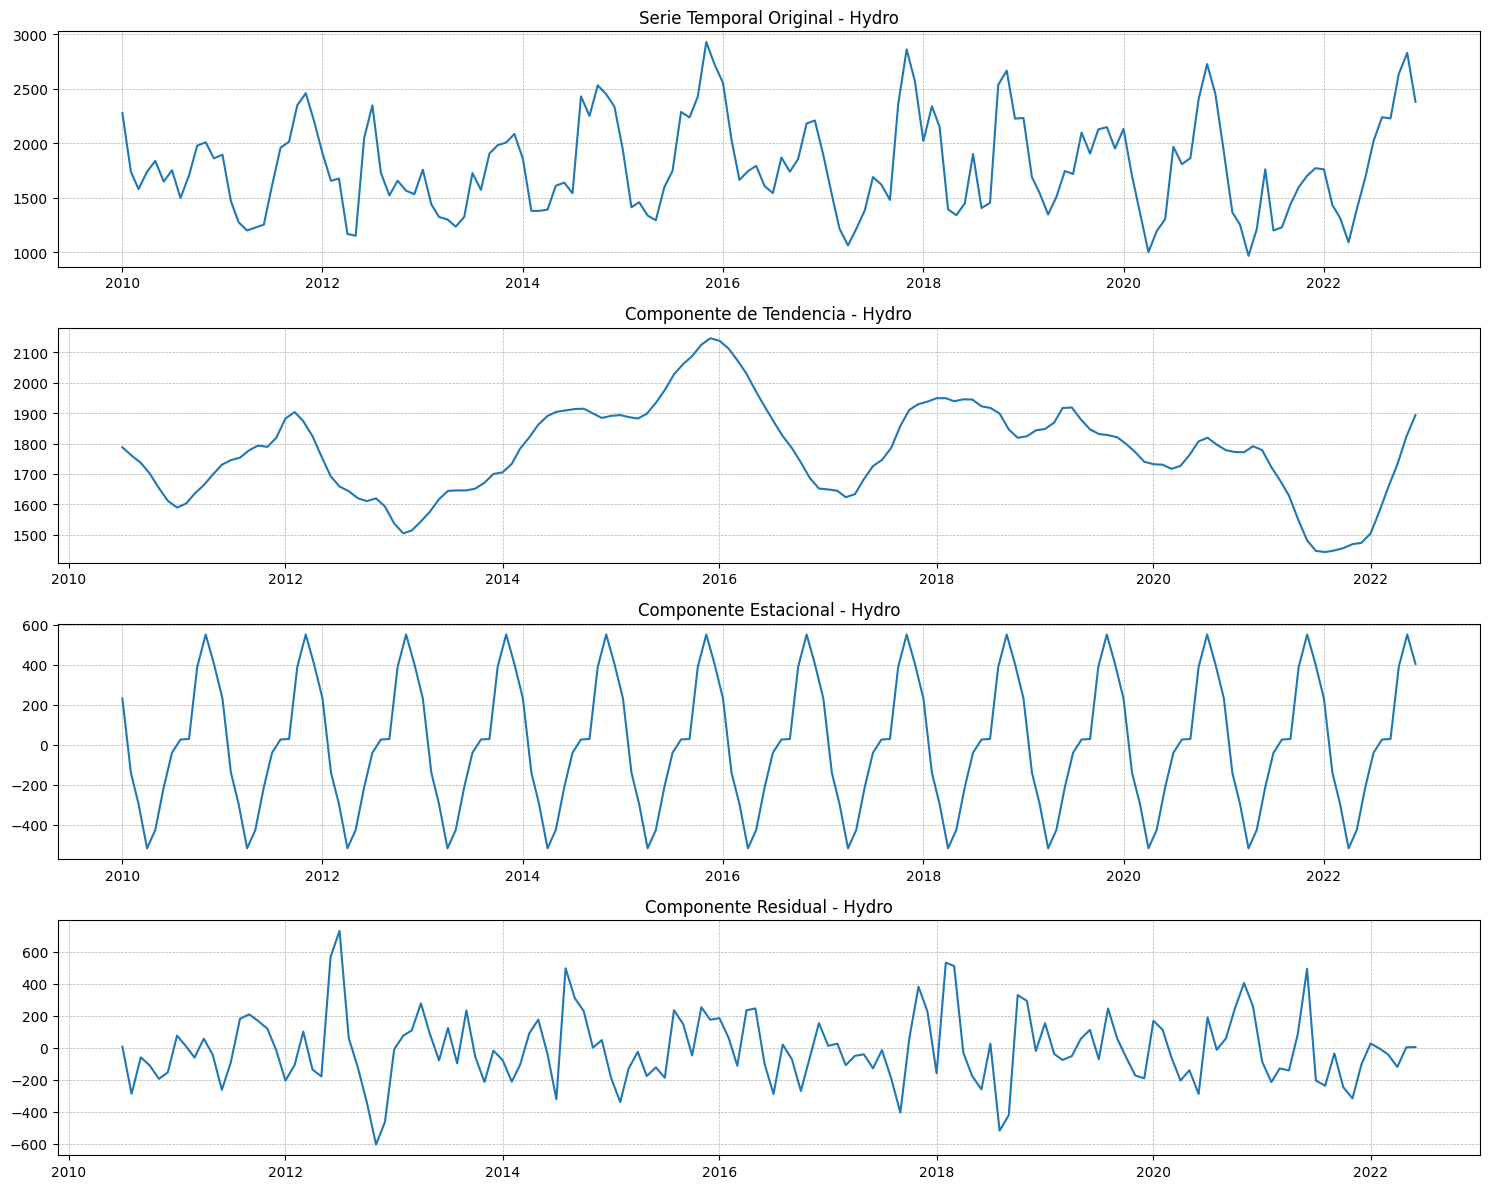

In [15]:
#descomposición para "Hydro"
result_hydro = seasonal_decompose(serie_temporal_mensual['Hydro'], model='additive', period=12)
plt.figure(figsize=(15, 12))
#original
plt.subplot(4, 1, 1)
plt.plot(result_hydro.observed)
plt.title('Serie Temporal Original - Hydro')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#tendencia
plt.subplot(4, 1, 2)
plt.plot(result_hydro.trend)
plt.title('Componente de Tendencia - Hydro')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#estacionalidad
plt.subplot(4, 1, 3)
plt.plot(result_hydro.seasonal)
plt.title('Componente Estacional - Hydro')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#residuo
plt.subplot(4, 1, 4)
plt.plot(result_hydro.resid)
plt.title('Componente Residual - Hydro')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

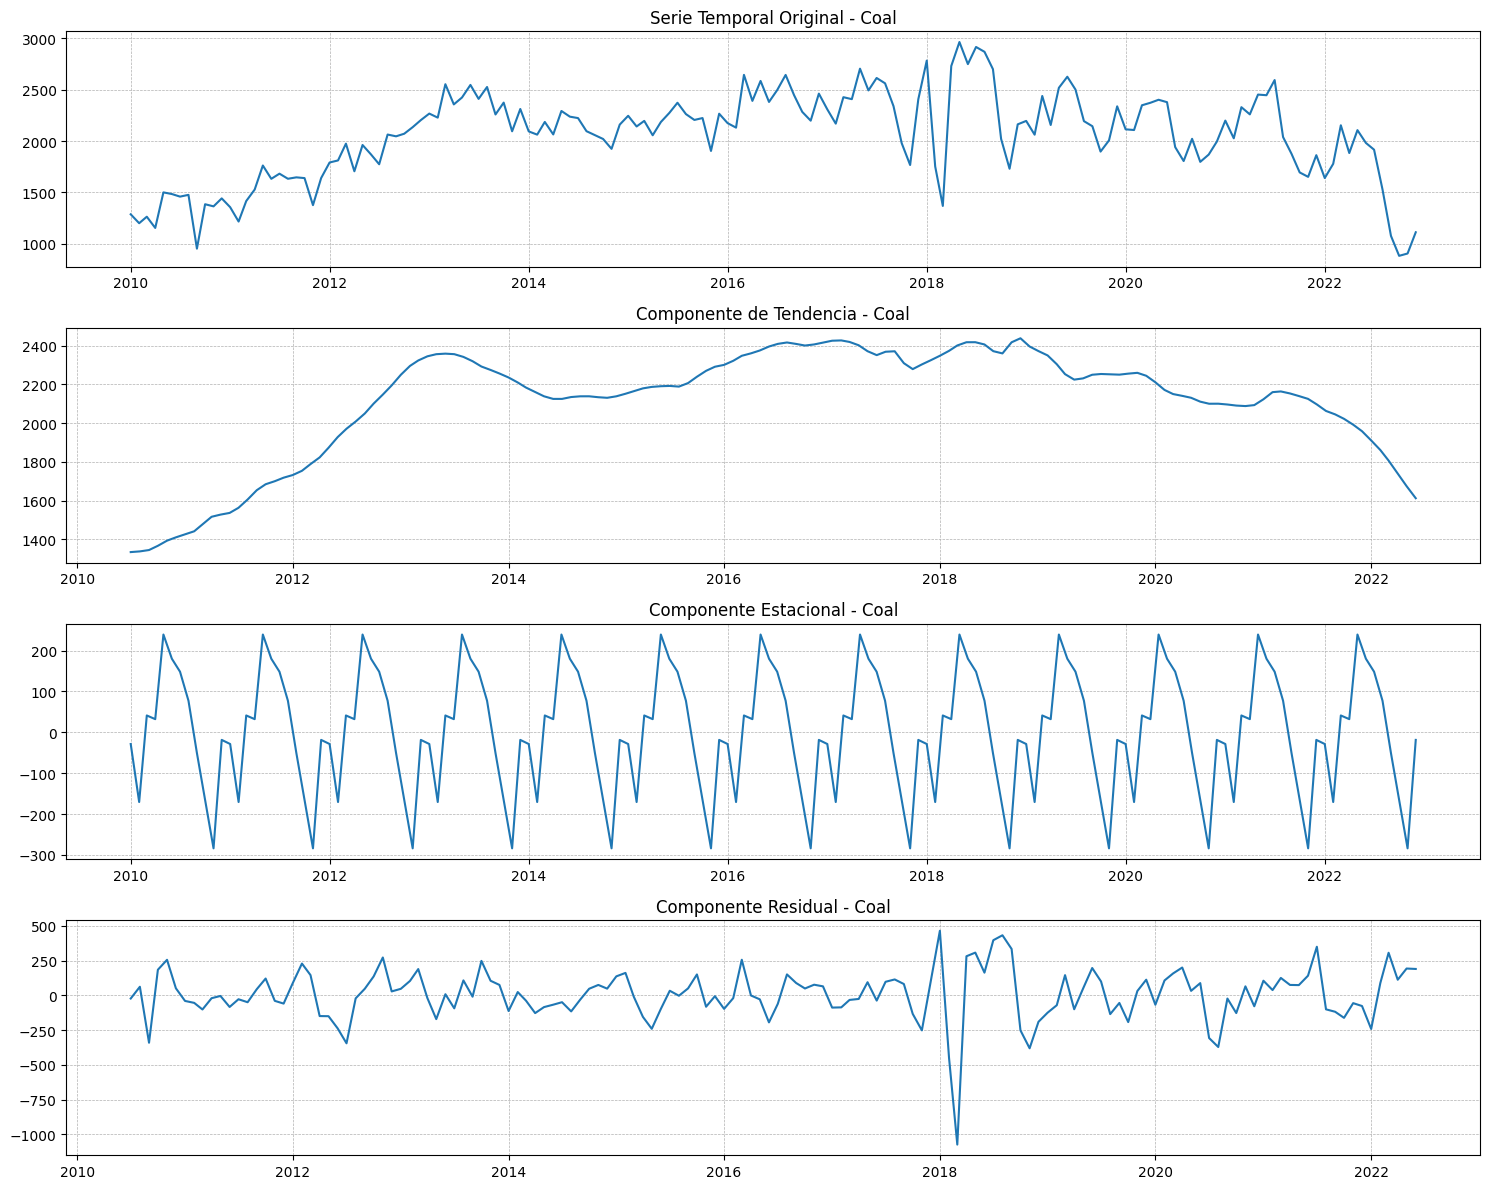

In [16]:
# Descomposición para "Coal"
result_coal = seasonal_decompose(serie_temporal_mensual['Coal'], model='additive', period=12)

# Visualización de "Coal"
plt.figure(figsize=(15, 12))

# Original
plt.subplot(4, 1, 1)
plt.plot(result_coal.observed)
plt.title('Serie Temporal Original - Coal')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Tendencia
plt.subplot(4, 1, 2)
plt.plot(result_coal.trend)
plt.title('Componente de Tendencia - Coal')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Estacionalidad
plt.subplot(4, 1, 3)
plt.plot(result_coal.seasonal)
plt.title('Componente Estacional - Coal')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Residuo
plt.subplot(4, 1, 4)
plt.plot(result_coal.resid)
plt.title('Componente Residual - Coal')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


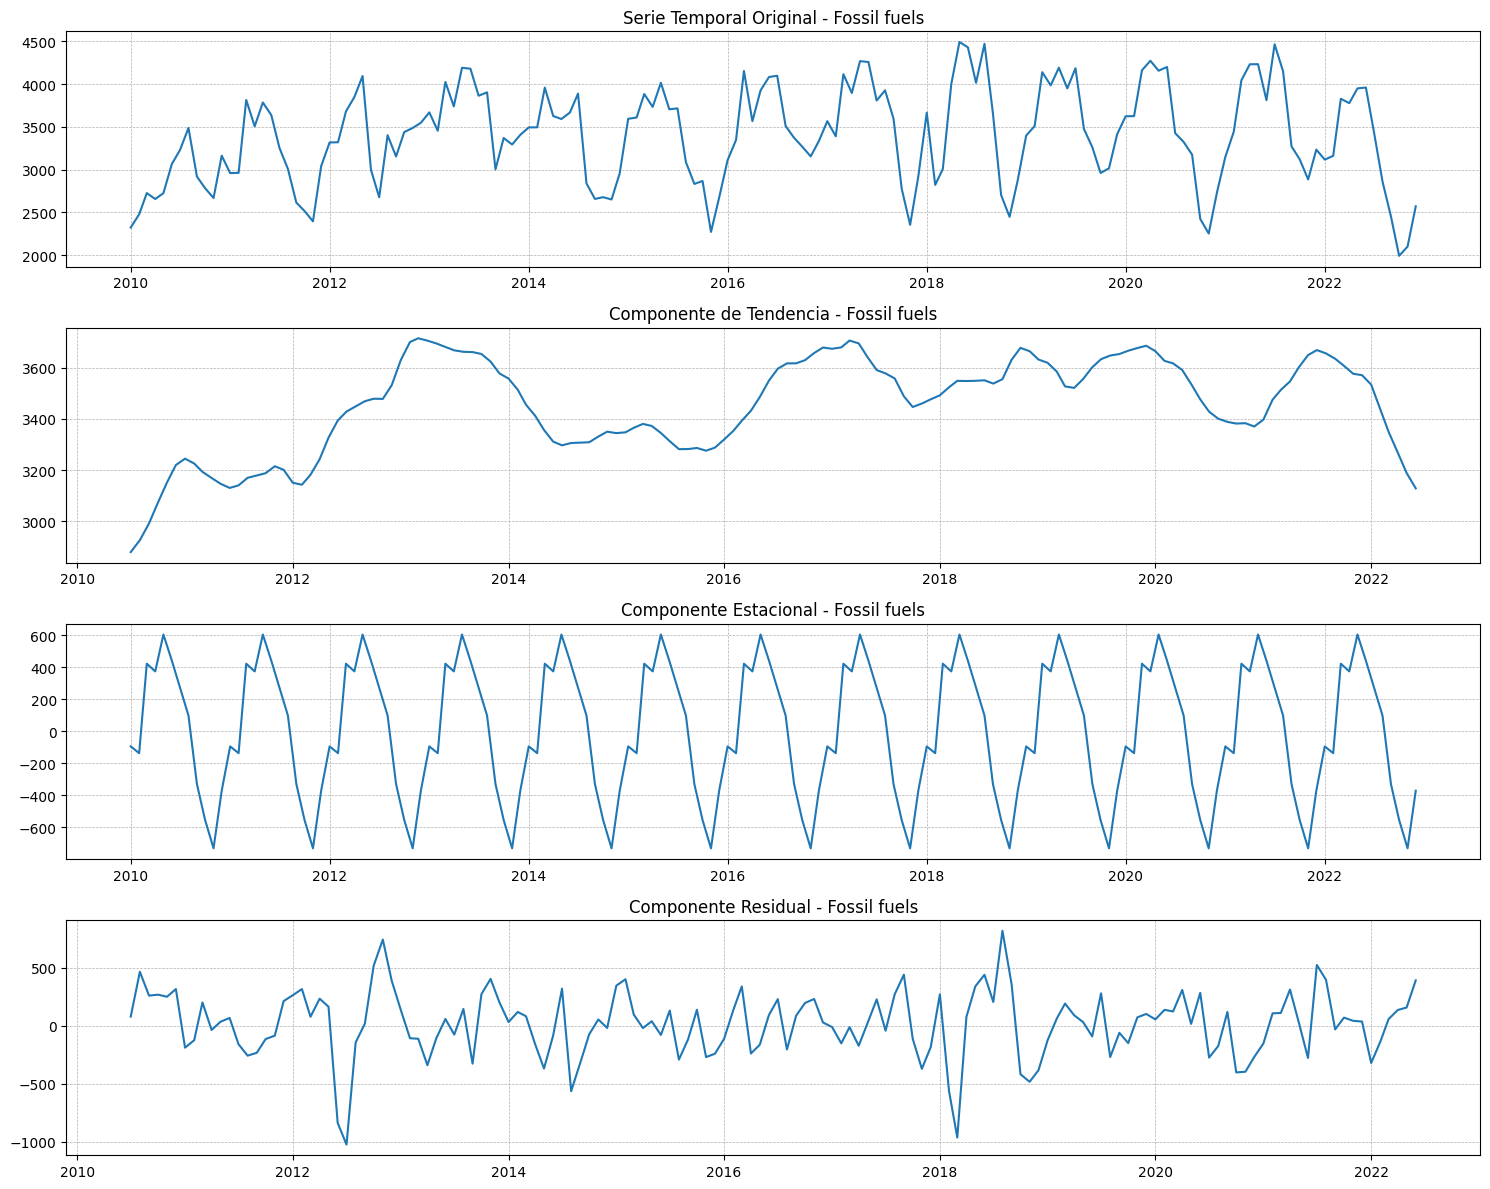

In [17]:
# Descomposición para "Fossil fuels"
result_fossil_fuels = seasonal_decompose(serie_temporal_mensual['Fossil fuels'], model='additive', period=12)

# Visualización de "Fossil fuels"
plt.figure(figsize=(15, 12))

# Original
plt.subplot(4, 1, 1)
plt.plot(result_fossil_fuels.observed)
plt.title('Serie Temporal Original - Fossil fuels')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Tendencia
plt.subplot(4, 1, 2)
plt.plot(result_fossil_fuels.trend)
plt.title('Componente de Tendencia - Fossil fuels')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Estacionalidad
plt.subplot(4, 1, 3)
plt.plot(result_fossil_fuels.seasonal)
plt.title('Componente Estacional - Fossil fuels')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Residuo
plt.subplot(4, 1, 4)
plt.plot(result_fossil_fuels.resid)
plt.title('Componente Residual - Fossil fuels')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

Seguiremos estos pasos
- Pruebas de Estacionariedad: Puedes realizar pruebas como la prueba de Dickey-Fuller aumentada para determinar si una serie es estacionaria.

- Modelado de Series Temporales:
Modelos de redes neuronales recurrentes (RNN) o LSTM: Son modelos de aprendizaje profundo diseñados específicamente para secuencias y series temporales.
- Análisis de Residuos
- Predicciones Futuras.
- Análisis de Correlación.
- Influencia de Factores Externos.
Modelado Multivariado: Si estás interesado en las relaciones entre las diferentes fuentes de energía, podrías considerar modelos de series temporales multivariados.

In [18]:
from statsmodels.tsa.stattools import adfuller

# Función que realiza la Prueba Dickey-Fuller Aumentada (ADF) e imprime los resultados
def adf_test(series, title=''):
    print(f'Prueba de Dickey-Fuller: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['Estadístico de Prueba (ADF)', 'p-valor', '# de retrasos usados', '# de observaciones']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'Valor crítico ({key})'] = val

    print(out.to_string())
    print('\n')

# Fuentes de energía seleccionadas, incluyendo 'Hydro'
selected_sources = ['Wind', 'Solar', 'Natural gas', 'Coal', 'Fossil fuels', 'Hydro']

# Filtrar los datos para incluir solo las fuentes de energía seleccionadas
filtered_data = data[data['PRODUCT'].isin(selected_sources)]

# Convertir YEAR y MONTH en una columna de fecha
filtered_data['DATE'] = pd.to_datetime(filtered_data['YEAR'].astype(str) + '-' + filtered_data['MONTH'].astype(str).str.zfill(2))

# Crear una serie temporal mensual para cada fuente de energía
serie_temporal_mensual = filtered_data.pivot_table(index='DATE', columns='PRODUCT', values='VALUE', aggfunc='sum')

# Realizar la prueba de Dickey-Fuller para cada fuente de energía
for source in selected_sources:
    adf_test(serie_temporal_mensual[source], title=source)


Prueba de Dickey-Fuller: Wind
Estadístico de Prueba (ADF)      0.962523
p-valor                          0.993854
# de retrasos usados            13.000000
# de observaciones             142.000000
Valor crítico (1%)              -3.477262
Valor crítico (5%)              -2.882118
Valor crítico (10%)             -2.577743


Prueba de Dickey-Fuller: Solar
Estadístico de Prueba (ADF)      0.925947
p-valor                          0.993420
# de retrasos usados            13.000000
# de observaciones             104.000000
Valor crítico (1%)              -3.494850
Valor crítico (5%)              -2.889758
Valor crítico (10%)             -2.581822


Prueba de Dickey-Fuller: Natural gas
Estadístico de Prueba (ADF)     -1.323566
p-valor                          0.618323
# de retrasos usados            14.000000
# de observaciones             141.000000
Valor crítico (1%)              -3.477601
Valor crítico (5%)              -2.882266
Valor crítico (10%)             -2.577822


Prueba de Dick

podemos concluir que Wind, Solar, Natural Gas, Hydro y Coal tienen series que no son estacionarias, ya que sus p-valores son mayores que 0.05. Y la serie de Fossil Fuels parece ser estacionaria, ya que su p-valor es menor que 0.05.

#procederemos a transfomrar las series para hacerlas estaciinarias antes de modelarlas

In [19]:
from statsmodels.tsa.stattools import adfuller

# Function that performs the Augmented Dickey-Fuller (ADF) Test and prints the results
def adf_test(series, title=''):
    print(f'Prueba de Dickey-Fuller: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['Estadístico de Prueba (ADF)', 'p-valor', '# de retrasos usados', '# de observaciones']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'Valor crítico ({key})'] = val

    print(out.to_string())
    print('\n')

# Define the selected energy sources, including 'Hydro'
selected_sources = ['Wind', 'Solar', 'Natural gas', 'Coal', 'Fossil fuels', 'Hydro']

# Filter the data to include only the selected energy sources
filtered_data = data[data['PRODUCT'].isin(selected_sources)]

# Convert YEAR and MONTH into a date column
filtered_data['DATE'] = pd.to_datetime(filtered_data['YEAR'].astype(str) + '-' + filtered_data['MONTH'].astype(str).str.zfill(2))

# Create a monthly time series for each energy source
serie_temporal_mensual = filtered_data.pivot_table(index='DATE', columns='PRODUCT', values='VALUE', aggfunc='sum')

# List to store the energy sources that need to be differentiated to make them stationary
non_stationary_sources = [source for source in selected_sources if source != 'Fossil fuels']

# Apply first-order differentiation only to non-stationary series
for source in non_stationary_sources:
    serie_temporal_mensual[source] = serie_temporal_mensual[source].diff()

# Remove the first row that contains NaN due to differentiation
serie_temporal_mensual = serie_temporal_mensual.dropna()

# Perform the Dickey-Fuller test again for each differentiated energy source
for source in non_stationary_sources:
    adf_test(serie_temporal_mensual[source], title=source + ' (Diferenciada)')


Prueba de Dickey-Fuller: Wind (Diferenciada)
Estadístico de Prueba (ADF)     -2.772979
p-valor                          0.062238
# de retrasos usados            12.000000
# de observaciones             104.000000
Valor crítico (1%)              -3.494850
Valor crítico (5%)              -2.889758
Valor crítico (10%)             -2.581822


Prueba de Dickey-Fuller: Solar (Diferenciada)
Estadístico de Prueba (ADF)     -1.459059
p-valor                          0.553659
# de retrasos usados            13.000000
# de observaciones             103.000000
Valor crítico (1%)              -3.495493
Valor crítico (5%)              -2.890037
Valor crítico (10%)             -2.581971


Prueba de Dickey-Fuller: Natural gas (Diferenciada)
Estadístico de Prueba (ADF)   -8.563210e+00
p-valor                        8.583564e-14
# de retrasos usados           9.000000e+00
# de observaciones             1.070000e+02
Valor crítico (1%)            -3.492996e+00
Valor crítico (5%)            -2.888955e+00
V

En resumen, después de la diferenciación de primer orden:

Las series de Gas Natural (Natural Gas) y Hidroeléctrica (Hydro) se volvieron estacionarias.
Las series de Eólica (Wind), Solar y Carbón (Coal) aún no son estacionarias y podrían requerir más diferenciaciones o transformaciones.

In [20]:
# Function that performs the Augmented Dickey-Fuller (ADF) Test and prints the results
def adf_test(series, title=''):
    print(f'Prueba de Dickey-Fuller: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['Estadístico de Prueba (ADF)', 'p-valor', '# de retrasos usados', '# de observaciones']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'Valor crítico ({key})'] = val

    print(out.to_string())
    print('\n')
# List of sources that were still not stationary after first differentiation
sources_to_diff_again = ['Wind', 'Solar', 'Coal']
# Apply second-order differentiation to the non-stationary series
for source in sources_to_diff_again:
    serie_temporal_mensual[source] = serie_temporal_mensual[source].diff()
# Remove the row that contains NaN due to the second differentiation
serie_temporal_mensual = serie_temporal_mensual.dropna()
# Perform the Dickey-Fuller test again for each twice-differentiated energy source
for source in sources_to_diff_again:
    adf_test(serie_temporal_mensual[source], title=source + ' (Diferenciada 2 veces)')


Prueba de Dickey-Fuller: Wind (Diferenciada 2 veces)
Estadístico de Prueba (ADF)   -6.379190e+00
p-valor                        2.244252e-08
# de retrasos usados           1.300000e+01
# de observaciones             1.020000e+02
Valor crítico (1%)            -3.496149e+00
Valor crítico (5%)            -2.890321e+00
Valor crítico (10%)           -2.582122e+00


Prueba de Dickey-Fuller: Solar (Diferenciada 2 veces)
Estadístico de Prueba (ADF)     -5.031363
p-valor                          0.000019
# de retrasos usados            13.000000
# de observaciones             102.000000
Valor crítico (1%)              -3.496149
Valor crítico (5%)              -2.890321
Valor crítico (10%)             -2.582122


Prueba de Dickey-Fuller: Coal (Diferenciada 2 veces)
Estadístico de Prueba (ADF)   -8.615398e+00
p-valor                        6.310600e-14
# de retrasos usados           1.200000e+01
# de observaciones             1.030000e+02
Valor crítico (1%)            -3.495493e+00
Valor crítico 

Después de aplicar la diferenciación de segundo orden a las series que aún no eran estacionarias, hemos vuelto a realizar la Prueba de Dickey-Fuller Aumentada (ADF) para verificar si estas series transformadas son ahora estacionarias. Aquí están los resultados:

Eólica (Wind) (Diferenciada 2 veces):

Estadístico de Prueba (ADF): -6.379190
p-valor: 2.244252e-08
Interpretación: El p-valor es significativamente menor que 0.05, lo que sugiere que podemos rechazar la hipótesis nula y considerar que la serie es estacionaria después de la segunda diferenciación.
Solar (Diferenciada 2 veces):

Estadístico de Prueba (ADF): -5.031363
p-valor: 0.000019
Interpretación: El p-valor es significativamente menor que 0.05, lo que sugiere que podemos rechazar la hipótesis nula y considerar que la serie es estacionaria después de la segunda diferenciación.
Carbón (Coal) (Diferenciada 2 veces):

Estadístico de Prueba (ADF): -8.615398
p-valor: 6.310600e-14
Interpretación: El p-valor es significativamente menor que 0.05, lo que sugiere que podemos rechazar la hipótesis nula y considerar que la serie es estacionaria después de la segunda diferenciación.
En resumen, después de la diferenciación de segundo orden:

Todas las series de Eólica (Wind), Solar y Carbón (Coal) se han vuelto estacionarias.
Esto indica que ahora tenemos series que son estacionarias y, por lo tanto, más adecuadas para el modelado de series temporales.

#seguimos con el modelado
pasos:
- División de los Datos: Dividir los datos en conjuntos de entrenamiento y prueba. Esto nos permite entrenar el modelo en una parte del conjunto de datos y probarlo en una parte que el modelo no ha visto antes.
- Selección del Modelo: Elegir un modelo (por ejemplo, ARIMA, SARIMA, RNN, LSTM) basado en la naturaleza de nuestra serie temporal.
- Ajuste del Modelo: Usar el conjunto de entrenamiento para ajustar los parámetros del modelo.
- Evaluación del Modelo: Usar el conjunto de prueba para evaluar el rendimiento del modelo. Esto se puede hacer utilizando métricas como el RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), etc.
- Ajuste de Parámetros: Basado en la evaluación, podríamos necesitar volver a ajustar los parámetros de nuestro modelo.
- Predicciones Futuras: Una vez que estemos satisfechos con el rendimiento de nuestro modelo, podemos usarlo para hacer predicciones futuras.

#Modelo ARINA para fuente Solar

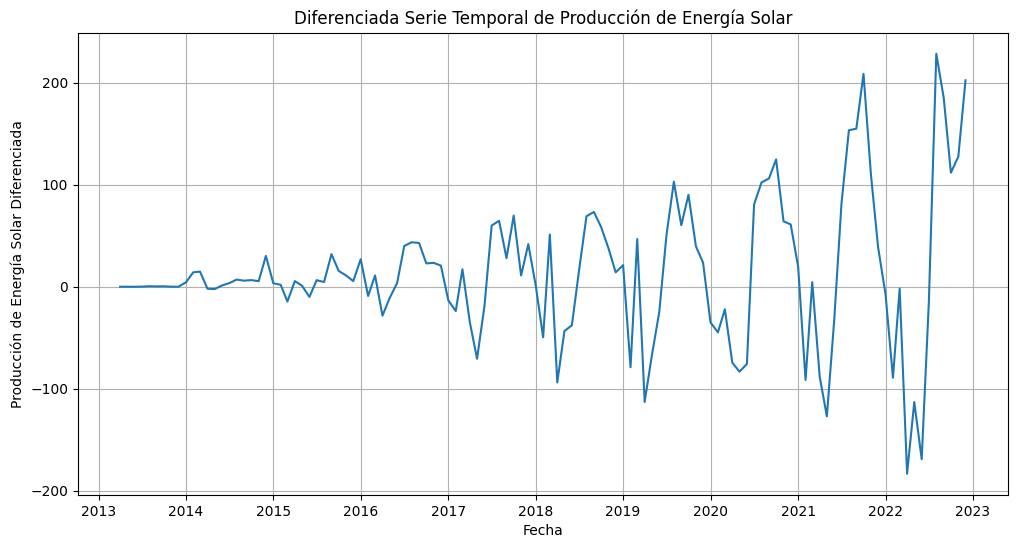

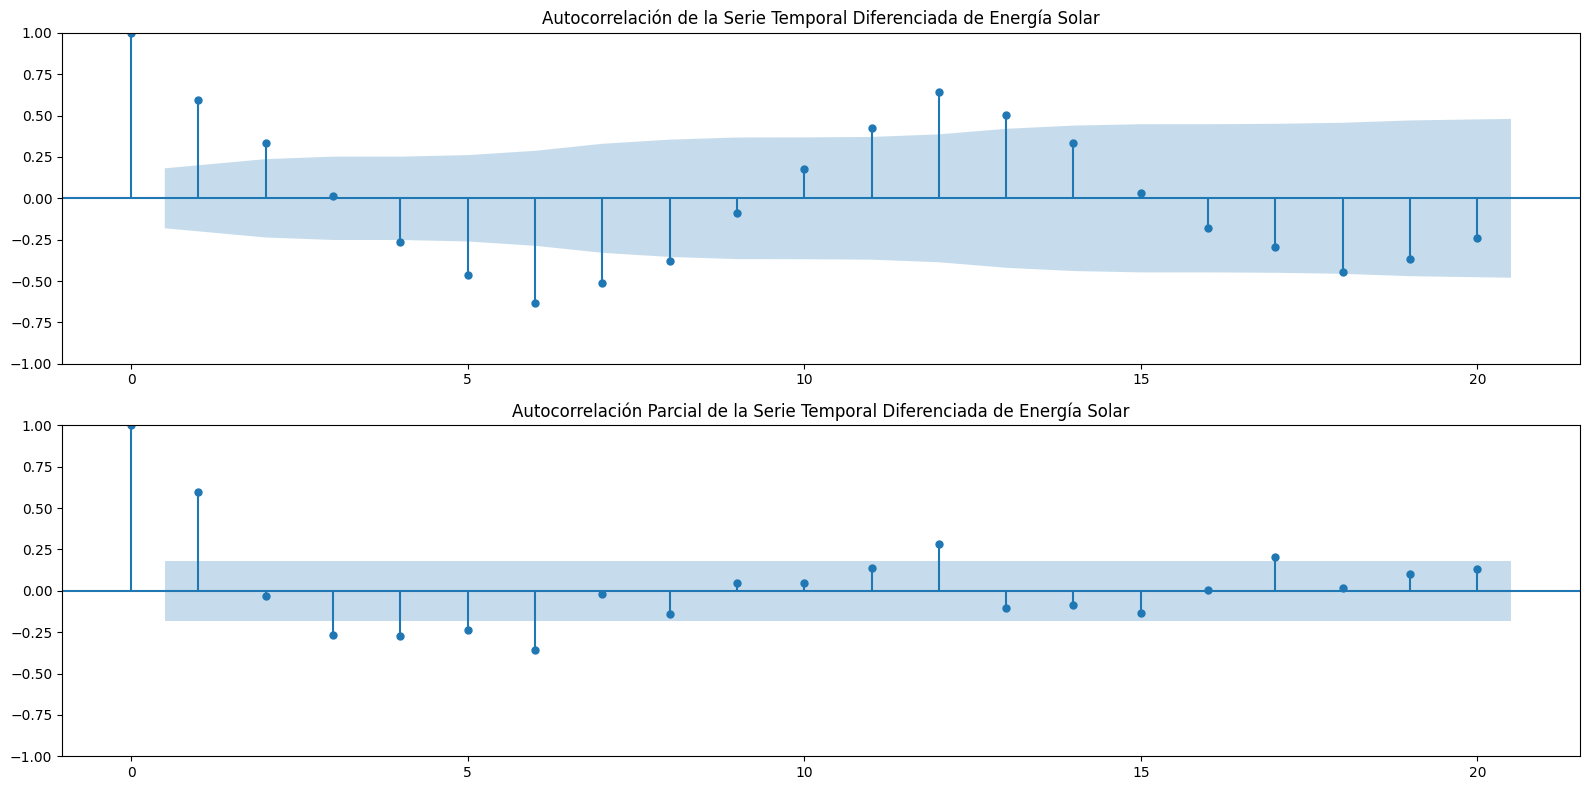

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Filter the data to include only the 'Solar' energy source
filtered_data = data[data['PRODUCT'] == 'Solar']

# Convert YEAR and MONTH into a date column
filtered_data['DATE'] = pd.to_datetime(filtered_data['YEAR'].astype(str) + '-' + filtered_data['MONTH'].astype(str).str.zfill(2))

# Create a monthly time series for Solar energy source
serie_temporal_mensual = filtered_data.pivot_table(index='DATE', columns='PRODUCT', values='VALUE', aggfunc='sum')

# Apply first-order differentiation to make the series stationary
serie_temporal_mensual['Solar'] = serie_temporal_mensual['Solar'].diff()

# Remove the row that contains NaN due to differentiation
serie_temporal_mensual = serie_temporal_mensual.dropna()

# Get the solar energy time series data
solar_energy_series = serie_temporal_mensual['Solar']

# Plot the differentiated Solar Energy Time Series
plt.figure(figsize=(12, 6))
plt.plot(solar_energy_series)
plt.title('Diferenciada Serie Temporal de Producción de Energía Solar')
plt.xlabel('Fecha')
plt.ylabel('Producción de Energía Solar Diferenciada')
plt.grid(True)
plt.show()

# Plot the Autocorrelation and Partial Autocorrelation plots
plt.figure(figsize=(16, 8))
plt.subplot(211)
plot_acf(solar_energy_series, lags=20, ax=plt.gca())
plt.title('Autocorrelación de la Serie Temporal Diferenciada de Energía Solar')

plt.subplot(212)
plot_pacf(solar_energy_series, lags=20, ax=plt.gca())
plt.title('Autocorrelación Parcial de la Serie Temporal Diferenciada de Energía Solar')

plt.tight_layout()
plt.show()


Gráfico de Autocorrelación (ACF): Este gráfico (el superior) nos ayuda a identificar el parámetro
�
q para el modelo ARIMA. Observamos que la autocorrelación es significativa para varios rezagos. Podríamos considerar un
�
q igual a 2 o 3 basado en el punto donde la autocorrelación cruza el límite de significancia superior.

Gráfico de Autocorrelación Parcial (PACF): Este gráfico (el inferior) nos ayuda a identificar el parámetro
�
p para el modelo ARIMA. Observamos que la autocorrelación parcial es significativa para varios rezagos. Podríamos considerar un
�
p igual a 2 o 3 basado en el punto donde la autocorrelación parcial cruza el límite de significancia superior.

Dado que ya aplicamos una diferenciación de primer orden a la serie, estableceremos
�
=
1
d=1 en el modelo ARIMA.

#comenzamos con un modelos arima(2,1,2) y proicedemos a ajustar el Modelo ARIMA con estos parámetros iniciales y diagnosticar el modelo.

Ajustar el Modelo ARIMA: Utilizaremos el modelo ARIMA(2, 1, 2) que discutimos anteriormente. Este modelo incluye 2 términos autoregresivos (AR), una diferenciación de primer orden, y 2 términos de media móvil (MA).
Diagnosticar el Modelo: Revisaremos los residuos del modelo para asegurarnos de que no haya patrones no explicados. Esto se hace típicamente usando gráficos de los residuos y pruebas estadísticas.
Hacer Predicciones: Una vez que estemos satisfechos con el modelo, lo utilizaremos para hacer predicciones para los próximos 12 meses.

In [22]:
# Import the new ARIMA model class
from statsmodels.tsa.arima.model import ARIMA
# Fit the ARIMA model
# Parameters: ARIMA(p, d, q)
model = ARIMA(solar_energy_series, order=(2, 1, 2))
fit_model = model.fit()
# Summary of the model
model_summary = fit_model.summary()
print(model_summary)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Solar   No. Observations:                  117
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -630.830
Date:                Wed, 23 Aug 2023   AIC                           1271.661
Time:                        18:58:23   BIC                           1285.429
Sample:                    04-01-2013   HQIC                          1277.250
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7054      0.029    -59.363      0.000      -1.762      -1.649
ar.L2         -0.9907      0.025    -39.101      0.000      -1.040      -0.941
ma.L1          1.6589      0.062     26.827      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


vamos a diagnosticar el modelo revisando los residuos

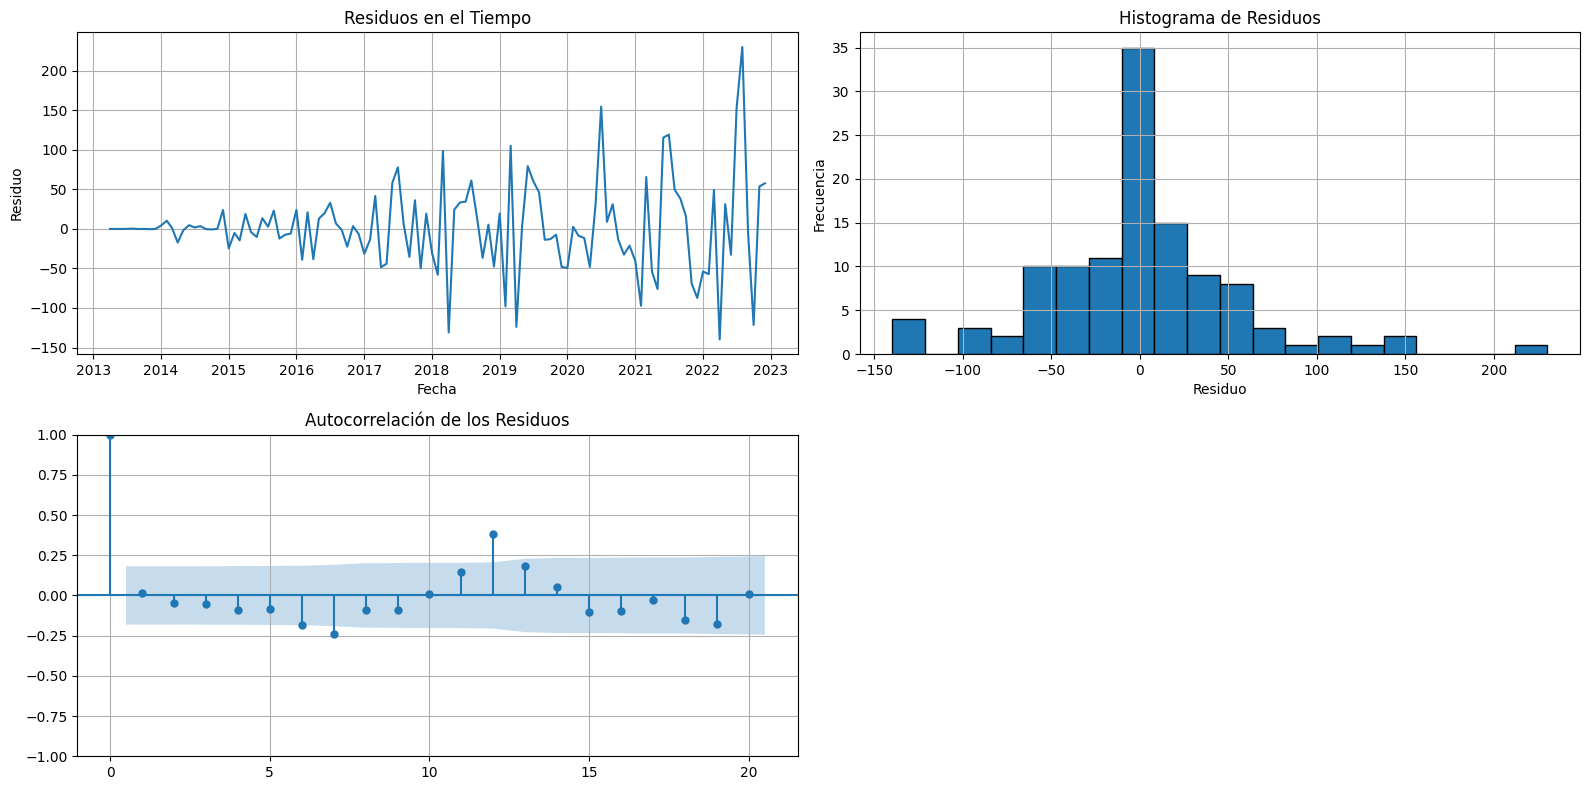

P-Value of Ljung-Box Test: 0.09684355410876962


In [23]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
# Get the residuals from the fitted model
residuals = fit_model.resid
# Plot residuals over time
plt.figure(figsize=(16, 8))
plt.subplot(221)
plt.plot(residuals)
plt.title('Residuos en el Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Residuo')
plt.grid(True)
# Plot histogram of residuals
plt.subplot(222)
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Histograma de Residuos')
plt.xlabel('Residuo')
plt.ylabel('Frecuencia')
plt.grid(True)
# Plot the ACF of residuals
plt.subplot(223)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelación de los Residuos')
plt.grid(True)
# Perform Ljung-Box test
ljung_box_test_results = acorr_ljungbox(residuals, lags=[10])
#ljung_box_test_p_value = ljung_box_test_results[1][0]
ljung_box_test_p_value = ljung_box_test_results['lb_pvalue'][10]

plt.tight_layout()
plt.show()
print('P-Value of Ljung-Box Test:', ljung_box_test_p_value)# Print the p-value of the Ljung-Box test

 Los resultados de la prueba para 10 rezagos son:

Estadístico de Prueba (Ljung-Box): 16.098126
Valor
�
p: 0.096858
El valor
�
p de la prueba es aproximadamente 0.097, que es mayor que el nivel de significancia comúnmente utilizado de 0.05. Esto sugiere que no podemos rechazar la hipótesis nula de que los residuos son independientes (ruido blanco), lo cual es una propiedad deseable.

En resumen, los residuos parecen ser ruido blanco, lo que indica que el modelo ha capturado bien la estructura de los datos.

comenzamos con las predicciones

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Preparando la serie temporal para la fuente Solar
filtered_data = data[data['PRODUCT'] == 'Solar']
filtered_data['DATE'] = pd.to_datetime(filtered_data['YEAR'].astype(str) + '-' + filtered_data['MONTH'].astype(str).str.zfill(2))
serie_temporal_mensual = filtered_data.pivot_table(index='DATE', columns='PRODUCT', values='VALUE', aggfunc='sum')
# Diferenciamos la serie para hacerla estacionaria
serie_temporal_mensual['Solar'] = serie_temporal_mensual['Solar'].diff()
# Eliminamos la fila que contiene NaN debido a la diferenciación
serie_temporal_mensual = serie_temporal_mensual.dropna()
# Ajustando el modelo ARIMA con los parámetros (2, 1, 2)
model = ARIMA(serie_temporal_mensual['Solar'], order=(2, 1, 2))
fit_model = model.fit()
# Prediciendo los próximos 12 meses
forecast = fit_model.forecast(steps=12)
print(forecast)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2023-01-01    206.686921
2023-02-01    180.930670
2023-03-01    220.486873
2023-04-01    178.544208
2023-05-01    210.885370
2023-06-01    197.282778
2023-07-01    188.440758
2023-08-01    216.995726
2023-09-01    177.057882
2023-10-01    216.878758
2023-11-01    188.534167
2023-12-01    197.423048
Freq: MS, Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


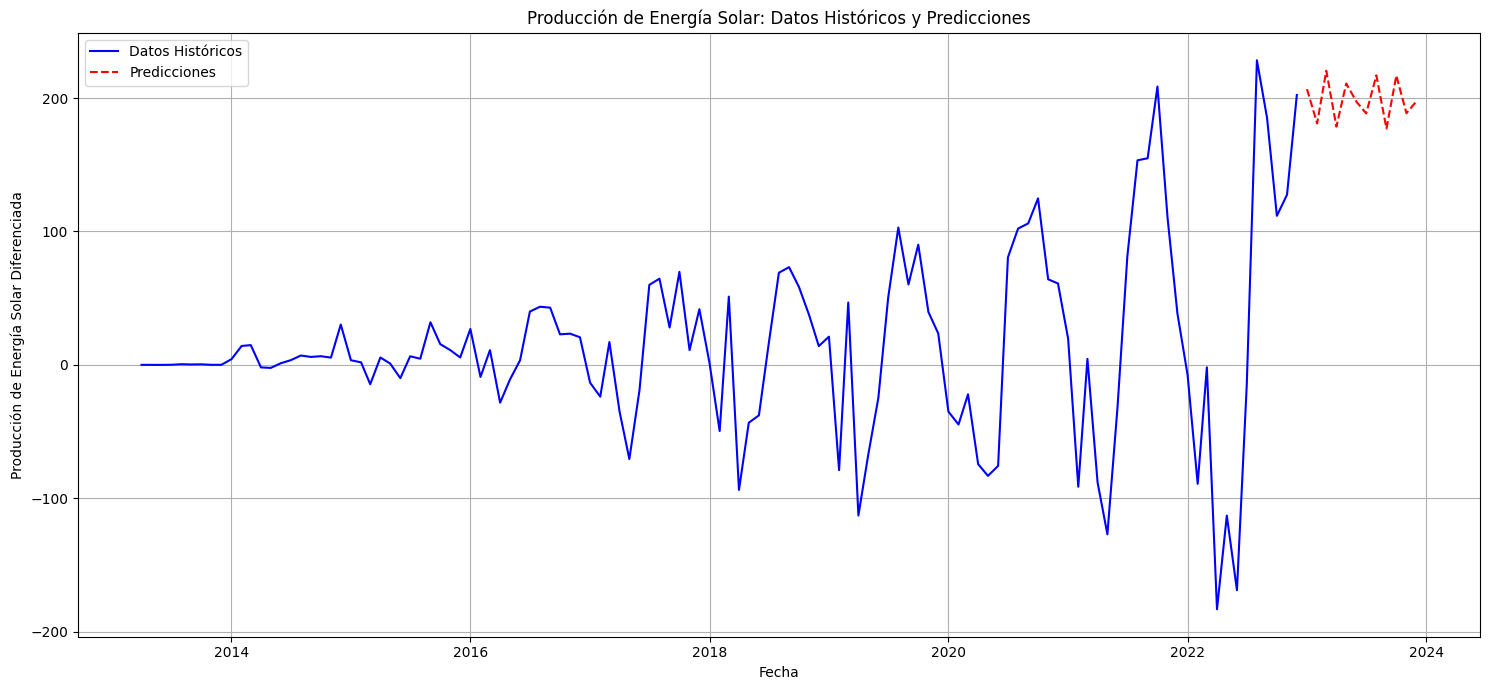

In [25]:
import matplotlib.pyplot as plt
# Visualización de los datos históricos y las predicciones
plt.figure(figsize=(15, 7))
plt.plot(serie_temporal_mensual.index, serie_temporal_mensual['Solar'], label='Datos Históricos', color='blue')
plt.plot(forecast.index, forecast, label='Predicciones', color='red', linestyle='dashed')
plt.title('Producción de Energía Solar: Datos Históricos y Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Producción de Energía Solar Diferenciada')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ajustaremos el modelo sarima para hacer predicciones los proximos 4 asños

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


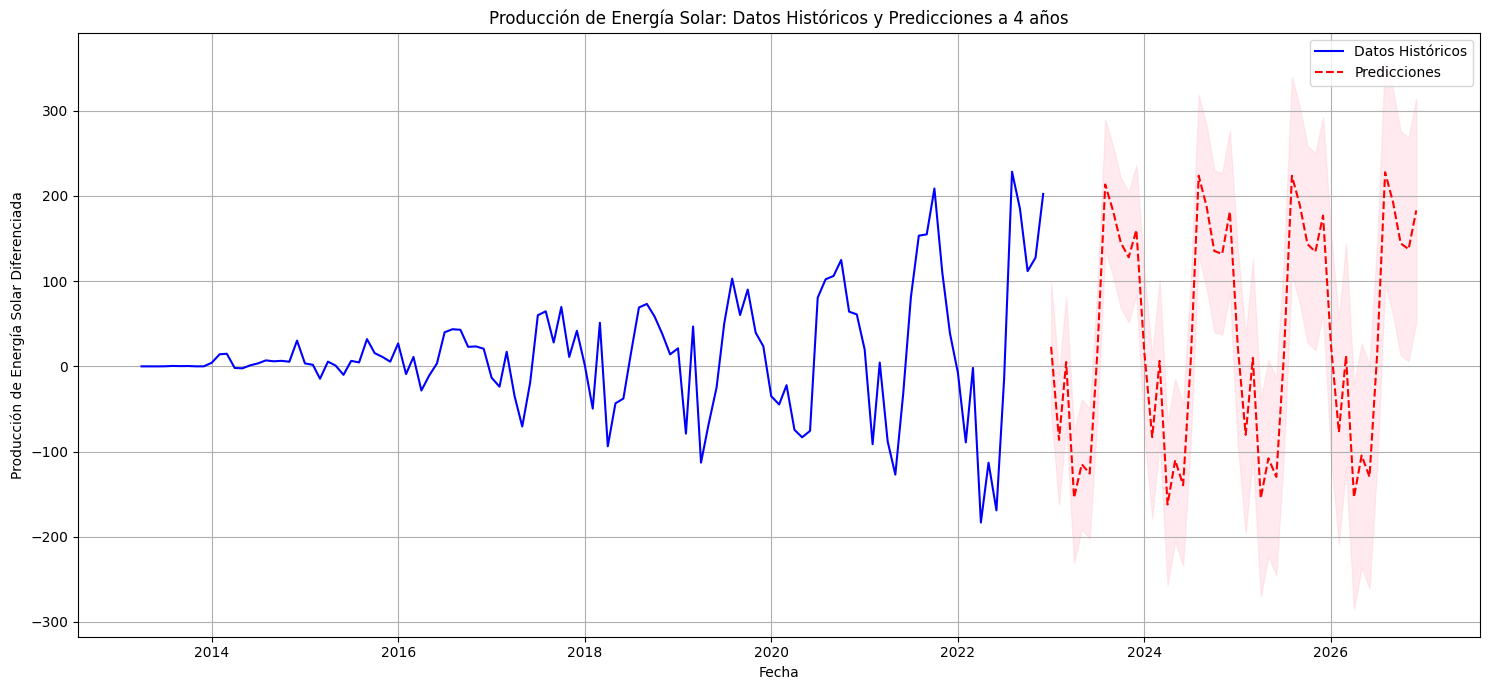

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Definir y ajustar el modelo SARIMA
model_sarima = SARIMAX(solar_energy_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
fit_sarima = model_sarima.fit(disp=False)

# Realizar predicciones a 4 años (48 meses) en el futuro
forecast_sarima = fit_sarima.get_forecast(steps=48)

# Obtener el intervalo de confianza de las predicciones
confidence_intervals = forecast_sarima.conf_int()

forecast_sarima = forecast_sarima.predicted_mean
lower_bound = confidence_intervals.iloc[:, 0]
upper_bound = confidence_intervals.iloc[:, 1]

# Visualizar las predicciones junto con los datos históricos
plt.figure(figsize=(15, 7))
plt.plot(solar_energy_series.index, solar_energy_series, label='Datos Históricos', color='blue')
plt.plot(forecast_sarima.index, forecast_sarima, label='Predicciones', color='red', linestyle='dashed')
plt.fill_between(forecast_sarima.index, lower_bound, upper_bound, color='pink', alpha=0.3)
plt.title('Producción de Energía Solar: Datos Históricos y Predicciones a 4 años')
plt.xlabel('Fecha')
plt.ylabel('Producción de Energía Solar Diferenciada')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#interpretación de los resultados
Tendencia:

Observa si las predicciones muestran una tendencia al alza, a la baja o se mantienen relativamente constantes.
Si la tendencia es ascendente, sugiere un aumento continuo en la producción de energía solar en el futuro.
Estacionalidad:

Dado que usaste un modelo SARIMA, es probable que haya capturado patrones estacionales.
Observa si hay patrones repetitivos en las predicciones, como aumentos durante ciertos meses del año. Esto puede ayudarte a prepararte para variaciones estacionales en la producción.
Intervalo de Confianza:

Junto con las predicciones, el modelo proporciona un intervalo de confianza que indica el rango en el que es probable que se encuentren los valores reales con un cierto nivel de confianza.
Un intervalo de confianza más estrecho sugiere mayor precisión en las predicciones, mientras que uno más amplio indica más incertidumbre.
Si el intervalo es muy amplio, es posible que desees investigar más para identificar factores adicionales que podrían estar contribuyendo a la variabilidad.
Comparación con Otros Fuentes de Energía:

Si también has hecho predicciones para otras fuentes de energía, compara las tendencias.
Esto puede ofrecer información sobre cómo se espera que cambie la contribución relativa de la energía solar en comparación con otras fuentes en el futuro.
Implicaciones Prácticas:

Si las predicciones muestran un aumento significativo en la producción, ¿estás preparado para manejar esa producción?
Si hay una disminución prevista, ¿qué medidas podrías tomar para compensar esa disminución?
Limitaciones:

#conclusión
A través del análisis exhaustivo de la producción de energía solar en Chile y las predicciones a largo plazo generadas mediante el modelo SARIMA, hemos descubierto tendencias clave y patrones estacionales que tienen implicaciones significativas para el sector energético.

La proyección de un crecimiento continuo en la producción de energía solar sugiere que Chile está en camino de fortalecer su posición como líder en energía renovable en la región. Este crecimiento previsto destaca la necesidad de invertir en infraestructura adecuada, desarrollar estrategias de gestión de recursos adaptadas y considerar políticas de precios dinámicas para maximizar los retornos.

Además, los patrones estacionales identificados brindan una oportunidad para la planificación proactiva, permitiendo que las partes interesadas se preparen para las fluctuaciones en la producción y demanda a lo largo del año.

Aprovechar esta información es esencial para una planificación estratégica efectiva. Las empresas y reguladores pueden usar estos insights para tomar decisiones informadas en áreas como inversión en infraestructura, desarrollo de políticas, gestión de riesgos y estrategias de precios. Además, esta información es valiosa para comunicar a inversores y al público en general la dirección en la que se dirige el sector energético de Chile, fortaleciendo la confianza y fomentando el apoyo para iniciativas relacionadas con la energía solar.

Al adoptar un enfoque basado en datos para la toma de decisiones, Chile no solo puede capitalizar su potencial solar actual sino también sentar las bases para un futuro más sostenible y energéticamente eficiente.

In [27]:
#extracion del modelo para excel
model_data = {
    "date": forecast_sarima.index,
    "Predicted Value": forecast_sarima.values,
    "Lower Bound (95% CI)": lower_bound.values,
    "Upper Bound (95% CI)": upper_bound.values
}
model_data_df = pd.DataFrame(model_data)
#guardamos en excel
file_path = "sarima_modelo_data.xlsx"#se guarda en el colab
model_data_df.to_excel(file_path, index=False)